# Overall Classification

3 different classification tasks:
* Ecoli
* Coliform
* Ecoli + Coliform

Classes are defined through thresholds

# BEAR IN MIND

* **Precision**: How many of our predictions are correct? Precision is the ability of a classifer not to label an instance positive that is actually negative. For each class it is defined as as the ratio of true positives to the sum of true and false positives. Said another way, “for all instances classified positive, what percent was correct?”

* **Recall**: How well do you notice the phenomenon? Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives. Said another way, “for all instances that were actually positive, what percent was classified correctly?”

* **F1 score**: The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. Generally speaking, F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.

* **Support**: Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing. Support doesn’t change between models but instead diagnoses the evaluation process.

In [442]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [443]:
data_path = os.path.join("..", "..", "data")

dir_store_path = os.path.join(data_path, "temporary results")

full_dataset_path = os.path.join(dir_store_path, "overall_dataset.xlsx")

# Load Data

In [444]:
full_df = pd.read_excel(full_dataset_path)

In [445]:
full_df.columns.to_list()

['DateTime',
 'Site',
 'Technician Water Quality',
 'Technician Counting',
 'Temp C_mean',
 'Temp C_std',
 'Ph_mean',
 'Ph_std',
 'Cond (ms)_mean',
 'Cond (ms)_std',
 'Coliform (1ml)_mean',
 'Coliform (1ml)_std',
 'Ecoli (1ml)_mean',
 'Ecoli (1ml)_std',
 'cso_hinterland',
 'cso_middle',
 'cso_sea',
 'rained',
 'mean_rainfall',
 'tide_value',
 'bacteria_sum']

In [446]:
full_df = full_df[full_df["DateTime"] > "2023-04-01"]

In [447]:
# start with site A
full_df = full_df[full_df["Site"] == "E"]

In [448]:
full_df = full_df.drop(
    columns=[
        "Site",
        "Technician Water Quality",
        "Technician Counting",
        "Temp C_std",
        "Ph_std",
        "Cond (ms)_std",
        "Coliform (1ml)_std",
        "Ecoli (1ml)_std",
    ]
)

# Bacteria Sum

In [449]:
bacteria_df = full_df.drop(columns=["Ecoli (1ml)_mean", "Coliform (1ml)_mean"])

<Axes: xlabel='bacteria_sum', ylabel='Count'>

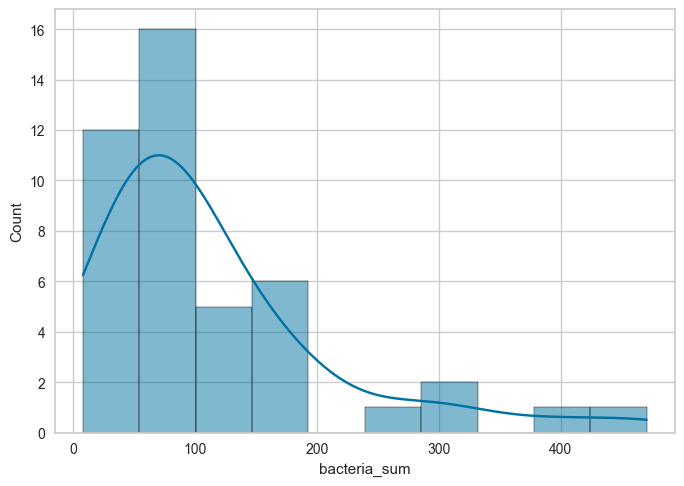

In [450]:
sns.histplot(bacteria_df["bacteria_sum"], kde=True)

In [451]:
# scale to log scale
bacteria_df["bacteria_sum"] = np.log10(bacteria_df["bacteria_sum"])

<Axes: xlabel='bacteria_sum', ylabel='Count'>

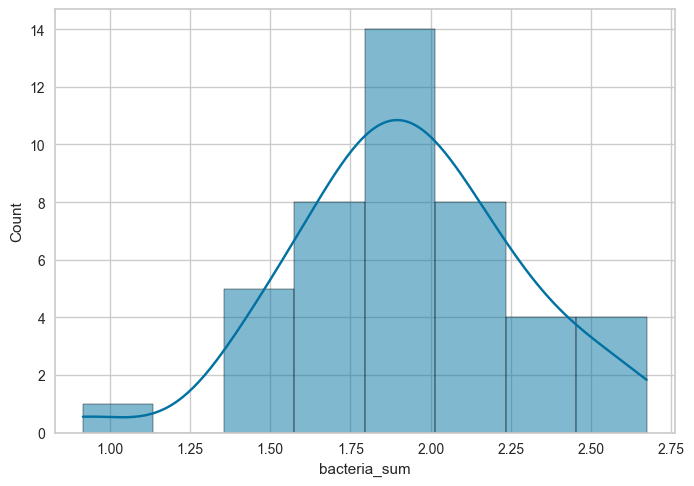

In [452]:
sns.histplot(bacteria_df["bacteria_sum"], kde=True)

## Define classes

In [453]:
print('Threshold:', 10 ** bacteria_df["bacteria_sum"].quantile(0.5))

Threshold: 81.18035476640887


In [454]:
# define function to classify ecoli levels based on quartiles
def ecoli_level(value):
    if value <= bacteria_df["bacteria_sum"].quantile(0.5):
        return "Low"
    else:
        return "High"

In [455]:
# define classes for Ecoli based on quantiles
bacteria_df["Class"] = bacteria_df["bacteria_sum"].apply(ecoli_level)

bacteria_df.drop(columns=["bacteria_sum"], inplace=True)

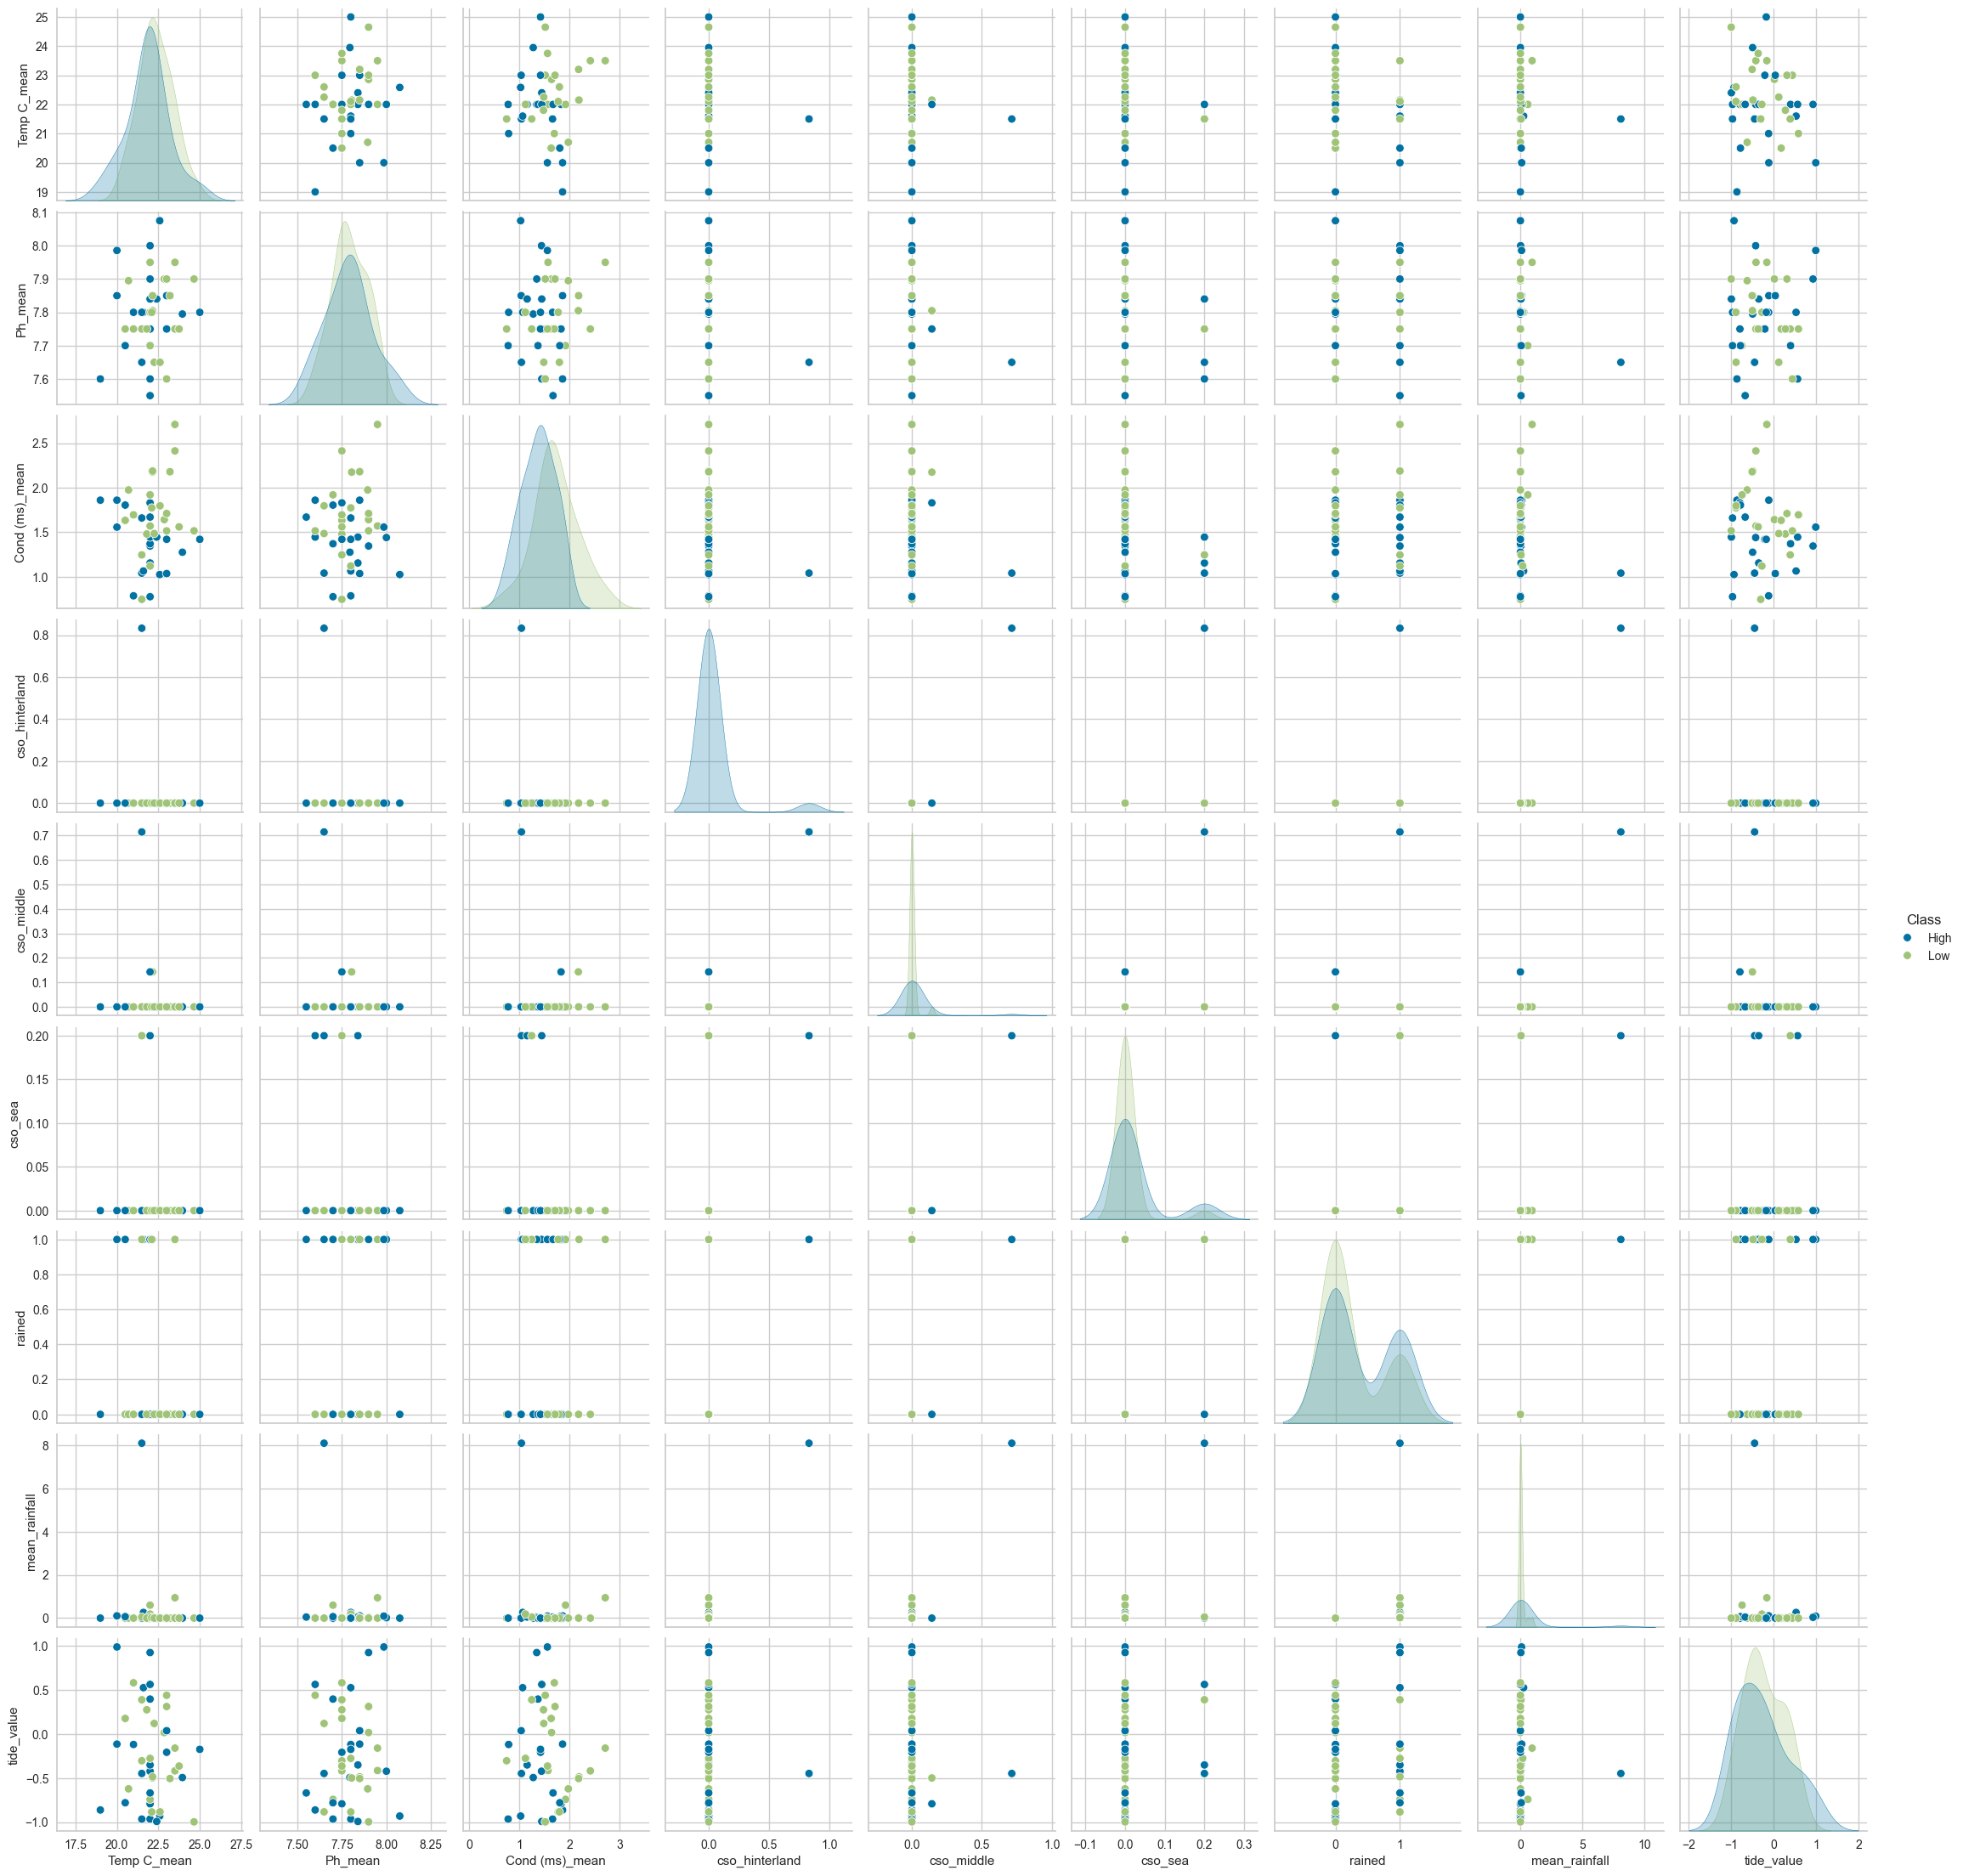

In [456]:
sns.pairplot(bacteria_df, hue="Class")

In [457]:
# count number of samples in each class
bacteria_df["Class"].value_counts()

Class
High    22
Low     22
Name: count, dtype: int64

# Perform Classification

In [458]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
import xgboost as xgb

In [459]:
bacteria_df.isna().sum()

DateTime          0
Temp C_mean       0
Ph_mean           0
Cond (ms)_mean    0
cso_hinterland    0
cso_middle        0
cso_sea           0
rained            0
mean_rainfall     0
tide_value        0
Class             0
dtype: int64

In [460]:
X = bacteria_df.drop(
    columns=[
        "DateTime",
        "Class",
    ]
).copy()
y = bacteria_df["Class"].copy()

y = y.map({"Low": 0, "High": 1})

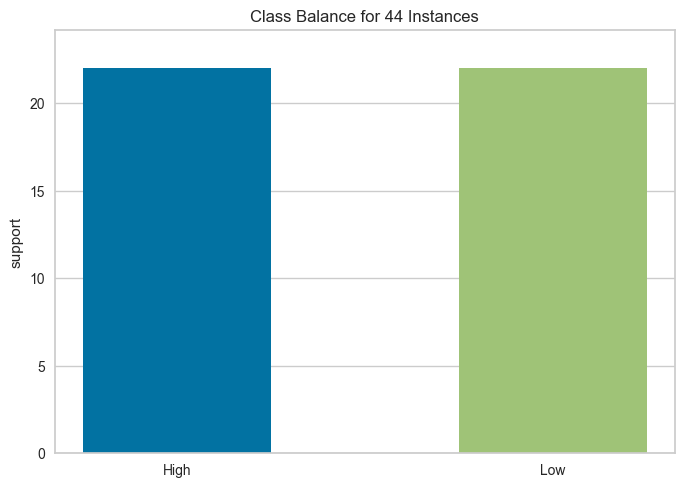

<Axes: title={'center': 'Class Balance for 44 Instances'}, ylabel='support'>

In [461]:
from yellowbrick.classifier import (
    ClassificationReport,
    ROCAUC,
    ClassPredictionError,
    ConfusionMatrix,
    PrecisionRecallCurve,
    ClassBalance,
)


classes = bacteria_df["Class"].unique()

visualizer = ClassBalance(labels=classes)
visualizer.fit(y)
visualizer.show()

# Feature Selection

In [462]:
import warnings
from sklearn import model_selection

In [463]:
%%script false --no-raise-error
from sklearn.feature_selection import SequentialFeatureSelector

selected_features = []

models = [
    LogisticRegression(),
    RandomForestClassifier(),
    DecisionTreeClassifier(),
    KNeighborsClassifier(),
    GaussianNB(),
    SVC(),
    LinearSVC(),
    SGDClassifier(),
    xgb.XGBClassifier(),
]

warnings.filterwarnings("ignore")

for model in models:
    print("=" * 80)
    print(model)
    print("=" * 80)
    print()

    cv = model_selection.LeaveOneOut()

    for direction in ["forward", "backward"]:
        print("Direction:", direction)
        print()
        sfs = SequentialFeatureSelector(
            model, n_features_to_select="auto", direction=direction, cv=cv
        )
        sfs.fit(X, y)
        print(X.columns[sfs.get_support()])
        print("-" * 10)

        selected_features.append(X.columns[sfs.get_support()].to_list())


# get the most common features
from collections import Counter

selected_features = Counter(
    [feature for sublist in selected_features for feature in sublist]
)

In [464]:
# selected_features

In [465]:
%%script false --no-raise-error
# Comment this line to keep all features

# Drop the features that are not selected at least half of the times

X.drop(
    columns=[
        "Cond (ms)_mean",
        "Ph_mean",
        "cso_hinterland",
        "cso_middle",
    ],
    inplace=True,
)

# Model Selection

In [466]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=42,
)

In [467]:
# scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [468]:
import optuna

In [469]:
%%script false --no-raise-error
from sklearn import model_selection


def objective(trial):
    classifier_name = trial.suggest_categorical(
        "classifier",
        [
            "RandomForest",
            "XGBoost",
            "LogisticRegression",
            "SVC",
            "KNN",
            "DecisionTree",
            "GaussianNB",
            "LinearSVC",
            "SGDClassifier",
        ],
    )

    if classifier_name == "RandomForest":
        model = RandomForestClassifier(
            random_state=42,
        )

    elif classifier_name == "XGBoost":
        model = xgb.XGBClassifier(
            random_state=42,
        )

    elif classifier_name == "LogisticRegression":
        model = LogisticRegression(
            random_state=42,
        )

    elif classifier_name == "SVC":
        model = SVC(
            random_state=42,
        )

    elif classifier_name == "KNN":
        model = KNeighborsClassifier()

    elif classifier_name == "DecisionTree":
        model = DecisionTreeClassifier(
            random_state=42,
        )

    elif classifier_name == "GaussianNB":
        model = GaussianNB()

    elif classifier_name == "LinearSVC":
        model = LinearSVC(
            random_state=42,
        )

    elif classifier_name == "SGDClassifier":
        model = SGDClassifier(
            random_state=42,
        )

    else:
        raise ValueError("Invalid classifier name")

    cv = model_selection.LeaveOneOut()
    results = model_selection.cross_val_score(
        estimator=model, X=X_train, y=y_train, cv=cv, scoring="f1_weighted"
    )
    return results.mean()

In [470]:
%%script false --no-raise-error
study = optuna.create_study(
    direction="maximize",
    storage="sqlite:///bacteria.sqlite3",
    study_name="Model Selection - Bacteria - Site A - After March",
    load_if_exists=True,
)
study.optimize(objective, n_trials=100, show_progress_bar=True)

Since the Condunctivity should be proportional with the tide_value, remove the cond.

Leave just mean_rainfall, tide_value, Temp, rained and cso_sea

In [471]:
# study.best_params

# Hyperparameter Tuning

In [472]:
from sklearn import model_selection


def objective(trial):
    classifier_name = trial.suggest_categorical(
        "classifier", ["RandomForest", "XGBoost"]
    )

    if classifier_name == "RandomForest":
        n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)
        max_depth = int(trial.suggest_float("max_depth", 10, 100, log=True))
        max_features = trial.suggest_categorical(
            "max_features", ["auto", "sqrt", "log2"]
        )
        criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            max_features=max_features,
            criterion=criterion,
            random_state=42,
        )

    elif classifier_name == "XGBoost":
        n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)
        max_depth = int(trial.suggest_float("max_depth", 10, 100, log=True))
        learning_rate = trial.suggest_float(
            "learning_rate", 0.01, 0.1, log=True
        )
        subsample = trial.suggest_float("subsample", 0.1, 1.0)
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0)
        model = xgb.XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            random_state=42,
        )

    else:
        raise ValueError("Invalid classifier name")

    cv = model_selection.LeaveOneOut()
    results = model_selection.cross_val_score(
        estimator=model, X=X_train, y=y_train, cv=cv, scoring="f1_weighted"
    )
    return results.mean()

In [473]:
study = optuna.create_study(
    direction="maximize",
    storage="sqlite:///bacteria.sqlite3",
    study_name="Hyperparameter Tuning - Bacteria - Site E - After March",
    load_if_exists=True,
)
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2024-03-15 00:45:16,623] A new study created in RDB with name: Hyperparameter Tuning - Bacteria - Site E - After March


  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:45:32,518] Trial 0 finished with value: 0.6285714285714286 and parameters: {'classifier': 'XGBoost', 'n_estimators': 580, 'max_depth': 39.537026723842985, 'learning_rate': 0.051723929276315216, 'subsample': 0.431960651808614, 'colsample_bytree': 0.6853676472189784}. Best is trial 0 with value: 0.6285714285714286.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:45:37,230] Trial 1 finished with value: 0.5714285714285714 and parameters: {'classifier': 'XGBoost', 'n_estimators': 460, 'max_depth': 50.57834246182234, 'learning_rate': 0.08001672422330003, 'subsample': 0.41705254607389475, 'colsample_bytree': 0.5457325072913846}. Best is trial 0 with value: 0.6285714285714286.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:45:44,174] Trial 2 finished with value: 0.6285714285714286 and parameters: {'classifier': 'XGBoost', 'n_estimators': 400, 'max_depth': 24.05262877426782, 'learning_rate': 0.018286565842556092, 'subsample': 0.5485176916046853, 'colsample_bytree': 0.6774847731064314}. Best is trial 0 with value: 0.6285714285714286.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:45:52,234] Trial 3 finished with value: 0.6 and parameters: {'classifier': 'XGBoost', 'n_estimators': 280, 'max_depth': 14.134546662612559, 'learning_rate': 0.04451315749709464, 'subsample': 0.3819226276869856, 'colsample_bytree': 0.7585264089633322}. Best is trial 0 with value: 0.6285714285714286.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or re

[I 2024-03-15 00:46:00,592] Trial 4 finished with value: 0.6 and parameters: {'classifier': 'RandomForest', 'n_estimators': 480, 'max_depth': 38.18062691038807, 'max_features': 'auto', 'criterion': 'entropy'}. Best is trial 0 with value: 0.6285714285714286.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or re

[I 2024-03-15 00:46:04,950] Trial 5 finished with value: 0.6 and parameters: {'classifier': 'RandomForest', 'n_estimators': 250, 'max_depth': 15.176249019905901, 'max_features': 'auto', 'criterion': 'entropy'}. Best is trial 0 with value: 0.6285714285714286.
[I 2024-03-15 00:46:14,489] Trial 6 finished with value: 0.6285714285714286 and parameters: {'classifier': 'RandomForest', 'n_estimators': 580, 'max_depth': 18.312441093426873, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 0 with value: 0.6285714285714286.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:46:33,198] Trial 7 finished with value: 0.6571428571428571 and parameters: {'classifier': 'XGBoost', 'n_estimators': 830, 'max_depth': 35.48706362175512, 'learning_rate': 0.09916760188448186, 'subsample': 0.2413469257107597, 'colsample_bytree': 0.3634584910660946}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:46:55,612] Trial 8 finished with value: 0.5428571428571428 and parameters: {'classifier': 'XGBoost', 'n_estimators': 800, 'max_depth': 19.237770054412298, 'learning_rate': 0.015980613502505472, 'subsample': 0.5208647364643478, 'colsample_bytree': 0.13853210347692776}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:47:11,401] Trial 9 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 960, 'max_depth': 33.471582240186656, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:47:25,608] Trial 10 finished with value: 0.6285714285714286 and parameters: {'classifier': 'XGBoost', 'n_estimators': 790, 'max_depth': 84.64676755056765, 'learning_rate': 0.09596266422434037, 'subsample': 0.12194756680258971, 'colsample_bytree': 0.29829139378251734}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:47:41,827] Trial 11 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 990, 'max_depth': 58.43922191606925, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:47:57,219] Trial 12 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 960, 'max_depth': 27.88816479103687, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:48:10,128] Trial 13 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 790, 'max_depth': 31.11640307631976, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:48:44,272] Trial 14 finished with value: 0.6571428571428571 and parameters: {'classifier': 'XGBoost', 'n_estimators': 880, 'max_depth': 62.19822955025975, 'learning_rate': 0.027180764803878703, 'subsample': 0.9419967104104519, 'colsample_bytree': 0.9945193025656798}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:48:55,922] Trial 15 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 690, 'max_depth': 39.617479702421406, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:49:07,587] Trial 16 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 690, 'max_depth': 24.095941459966497, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:49:10,187] Trial 17 finished with value: 0.4 and parameters: {'classifier': 'XGBoost', 'n_estimators': 120, 'max_depth': 94.27709337447686, 'learning_rate': 0.05584963066772812, 'subsample': 0.10622098690872919, 'colsample_bytree': 0.3898598488213714}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:49:39,290] Trial 18 finished with value: 0.6 and parameters: {'classifier': 'XGBoost', 'n_estimators': 920, 'max_depth': 51.59098382821804, 'learning_rate': 0.010101436103433697, 'subsample': 0.8098183190276033, 'colsample_bytree': 0.13017611740892046}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:49:50,245] Trial 19 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 690, 'max_depth': 11.99049777663801, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:50:04,443] Trial 20 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 860, 'max_depth': 10.219205784919605, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:50:22,050] Trial 21 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 1000, 'max_depth': 69.02805554278137, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:50:38,460] Trial 22 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 1000, 'max_depth': 48.616071366116856, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:50:52,820] Trial 23 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 890, 'max_depth': 64.60575580601706, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:51:06,463] Trial 24 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 850, 'max_depth': 35.17252018725839, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or re

[I 2024-03-15 00:51:22,531] Trial 25 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 940, 'max_depth': 44.17911078913467, 'max_features': 'auto', 'criterion': 'gini'}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:51:50,570] Trial 26 finished with value: 0.6285714285714286 and parameters: {'classifier': 'XGBoost', 'n_estimators': 750, 'max_depth': 27.925366646663623, 'learning_rate': 0.031182442957272138, 'subsample': 0.2513802398424387, 'colsample_bytree': 0.3993674233551539}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:52:06,346] Trial 27 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 1000, 'max_depth': 73.2364860100443, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:52:39,019] Trial 28 finished with value: 0.6285714285714286 and parameters: {'classifier': 'XGBoost', 'n_estimators': 730, 'max_depth': 58.760410639262226, 'learning_rate': 0.06777826565916678, 'subsample': 0.6948216975645324, 'colsample_bytree': 0.5189589747024486}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:52:51,910] Trial 29 finished with value: 0.6285714285714286 and parameters: {'classifier': 'XGBoost', 'n_estimators': 600, 'max_depth': 32.49320553358697, 'learning_rate': 0.038417855718019936, 'subsample': 0.2567699352886815, 'colsample_bytree': 0.2563008700608887}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:53:05,230] Trial 30 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 830, 'max_depth': 41.93376395661913, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:53:20,084] Trial 31 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 930, 'max_depth': 26.58475696052614, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:53:35,754] Trial 32 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 940, 'max_depth': 29.75352469614118, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:53:50,674] Trial 33 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 930, 'max_depth': 20.73749139246041, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:54:06,383] Trial 34 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 980, 'max_depth': 23.49991692041616, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:54:41,995] Trial 35 finished with value: 0.6 and parameters: {'classifier': 'XGBoost', 'n_estimators': 880, 'max_depth': 35.26536662145403, 'learning_rate': 0.021645569220715456, 'subsample': 0.7140721265083174, 'colsample_bytree': 0.8889908165696387}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or re

[I 2024-03-15 00:54:52,666] Trial 36 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 630, 'max_depth': 52.197972912299704, 'max_features': 'auto', 'criterion': 'gini'}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:55:04,665] Trial 37 finished with value: 0.6 and parameters: {'classifier': 'XGBoost', 'n_estimators': 510, 'max_depth': 43.98508990529064, 'learning_rate': 0.010502385958759427, 'subsample': 0.2686472766046043, 'colsample_bytree': 0.45194788070911773}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:55:19,993] Trial 38 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 950, 'max_depth': 15.394823721195133, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:55:26,533] Trial 39 finished with value: 0.6285714285714286 and parameters: {'classifier': 'RandomForest', 'n_estimators': 400, 'max_depth': 34.79962371569297, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:55:50,274] Trial 40 finished with value: 0.6 and parameters: {'classifier': 'XGBoost', 'n_estimators': 800, 'max_depth': 21.854312390607507, 'learning_rate': 0.0990861199764258, 'subsample': 0.6546465115446602, 'colsample_bytree': 0.2791980942453893}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:56:03,492] Trial 41 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 820, 'max_depth': 29.954645485163482, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:56:15,658] Trial 42 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 770, 'max_depth': 25.80043813751018, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:56:29,256] Trial 43 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 890, 'max_depth': 17.546783913695492, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:56:44,008] Trial 44 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 960, 'max_depth': 32.45433102261493, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:56:57,746] Trial 45 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 890, 'max_depth': 38.121886637779696, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:57:02,225] Trial 46 finished with value: 0.6285714285714286 and parameters: {'classifier': 'XGBoost', 'n_estimators': 650, 'max_depth': 56.91551143294707, 'learning_rate': 0.07351671054455253, 'subsample': 0.962594270229635, 'colsample_bytree': 0.6499154900846684}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or re

[I 2024-03-15 00:57:07,370] Trial 47 finished with value: 0.6 and parameters: {'classifier': 'RandomForest', 'n_estimators': 310, 'max_depth': 27.927859405006508, 'max_features': 'auto', 'criterion': 'entropy'}. Best is trial 7 with value: 0.6571428571428571.
[I 2024-03-15 00:57:20,361] Trial 48 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 840, 'max_depth': 47.6346628772658, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:57:24,737] Trial 49 finished with value: 0.5428571428571428 and parameters: {'classifier': 'XGBoost', 'n_estimators': 740, 'max_depth': 84.78741858266648, 'learning_rate': 0.014341554821665308, 'subsample': 0.2041072030164253, 'colsample_bytree': 0.8167787278455152}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or re

[I 2024-03-15 00:57:26,491] Trial 50 finished with value: 0.6285714285714286 and parameters: {'classifier': 'RandomForest', 'n_estimators': 100, 'max_depth': 40.22326596818425, 'max_features': 'auto', 'criterion': 'entropy'}. Best is trial 7 with value: 0.6571428571428571.
[I 2024-03-15 00:57:33,571] Trial 51 finished with value: 0.6571428571428571 and parameters: {'classifier': 'XGBoost', 'n_estimators': 910, 'max_depth': 72.93681943304873, 'learning_rate': 0.027374992674034367, 'subsample': 0.9173536649943282, 'colsample_bytree': 0.9902316996236012}. Best is trial 7 with value: 0.6571428571428571.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:57:41,211] Trial 52 finished with value: 0.6857142857142857 and parameters: {'classifier': 'XGBoost', 'n_estimators': 970, 'max_depth': 64.01355674894887, 'learning_rate': 0.024783564737035794, 'subsample': 0.8685125087077763, 'colsample_bytree': 0.9113686188710808}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:57:48,805] Trial 53 finished with value: 0.6285714285714286 and parameters: {'classifier': 'XGBoost', 'n_estimators': 970, 'max_depth': 24.602740782449892, 'learning_rate': 0.0230891665371171, 'subsample': 0.8279451633895002, 'colsample_bytree': 0.6111394484404318}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:57:55,471] Trial 54 finished with value: 0.6 and parameters: {'classifier': 'XGBoost', 'n_estimators': 970, 'max_depth': 81.9667569159844, 'learning_rate': 0.03843349601581378, 'subsample': 0.619650275873334, 'colsample_bytree': 0.8481107474924169}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:58:02,872] Trial 55 finished with value: 0.5714285714285714 and parameters: {'classifier': 'XGBoost', 'n_estimators': 870, 'max_depth': 36.00931900317313, 'learning_rate': 0.013586630040935627, 'subsample': 0.7941534292865767, 'colsample_bytree': 0.47916686336541403}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:58:07,811] Trial 56 finished with value: 0.6285714285714286 and parameters: {'classifier': 'XGBoost', 'n_estimators': 1000, 'max_depth': 99.47455166070742, 'learning_rate': 0.03723252854128302, 'subsample': 0.3373708665936289, 'colsample_bytree': 0.20075380001682042}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:58:21,801] Trial 57 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 910, 'max_depth': 30.174247120221008, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:58:34,092] Trial 58 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 800, 'max_depth': 53.903269887050726, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:58:39,248] Trial 59 finished with value: 0.6 and parameters: {'classifier': 'XGBoost', 'n_estimators': 850, 'max_depth': 64.66061308887448, 'learning_rate': 0.05278021556401902, 'subsample': 0.48967738547777856, 'colsample_bytree': 0.3690745303765938}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:58:53,316] Trial 60 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 910, 'max_depth': 46.314089647574725, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:59:01,112] Trial 61 finished with value: 0.6285714285714286 and parameters: {'classifier': 'XGBoost', 'n_estimators': 970, 'max_depth': 66.36107271336, 'learning_rate': 0.025952573177542227, 'subsample': 0.9521288407232431, 'colsample_bytree': 0.926196680949966}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:59:08,258] Trial 62 finished with value: 0.6285714285714286 and parameters: {'classifier': 'XGBoost', 'n_estimators': 870, 'max_depth': 75.56935726086257, 'learning_rate': 0.030019346728431484, 'subsample': 0.9964065657640047, 'colsample_bytree': 0.9551807364596736}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:59:14,738] Trial 63 finished with value: 0.6285714285714286 and parameters: {'classifier': 'XGBoost', 'n_estimators': 700, 'max_depth': 58.69143851155968, 'learning_rate': 0.02001618896953902, 'subsample': 0.8868254708344497, 'colsample_bytree': 0.7928921667586397}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:59:22,601] Trial 64 finished with value: 0.6857142857142857 and parameters: {'classifier': 'XGBoost', 'n_estimators': 940, 'max_depth': 32.564053971053816, 'learning_rate': 0.025227385191422952, 'subsample': 0.8788835794118175, 'colsample_bytree': 0.9900298948171974}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:59:29,148] Trial 65 finished with value: 0.6285714285714286 and parameters: {'classifier': 'XGBoost', 'n_estimators': 1000, 'max_depth': 32.85683349347225, 'learning_rate': 0.04659239707797882, 'subsample': 0.7522228374285775, 'colsample_bytree': 0.7278869238907846}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:59:36,799] Trial 66 finished with value: 0.6 and parameters: {'classifier': 'XGBoost', 'n_estimators': 950, 'max_depth': 38.6829445469557, 'learning_rate': 0.017995897568686876, 'subsample': 0.8478239667875058, 'colsample_bytree': 0.6058601087068138}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:59:50,896] Trial 67 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 920, 'max_depth': 27.644099431517613, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:59:53,605] Trial 68 finished with value: 0.6 and parameters: {'classifier': 'RandomForest', 'n_estimators': 170, 'max_depth': 23.04378833251626, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 00:59:57,110] Trial 69 finished with value: 0.6 and parameters: {'classifier': 'XGBoost', 'n_estimators': 530, 'max_depth': 43.02257445975595, 'learning_rate': 0.05921130663926377, 'subsample': 0.610360668138744, 'colsample_bytree': 0.8697182940659377}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or re

[I 2024-03-15 01:00:09,655] Trial 70 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 780, 'max_depth': 25.65893633011137, 'max_features': 'auto', 'criterion': 'entropy'}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 01:00:16,256] Trial 71 finished with value: 0.6285714285714286 and parameters: {'classifier': 'XGBoost', 'n_estimators': 830, 'max_depth': 62.47393063964553, 'learning_rate': 0.024170463461538828, 'subsample': 0.8841523534206825, 'colsample_bytree': 0.9861881814074112}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 01:00:23,810] Trial 72 finished with value: 0.6571428571428571 and parameters: {'classifier': 'XGBoost', 'n_estimators': 940, 'max_depth': 30.789874769315215, 'learning_rate': 0.03442700122877219, 'subsample': 0.7733373108336621, 'colsample_bytree': 0.9248969185109207}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 01:00:30,752] Trial 73 finished with value: 0.6285714285714286 and parameters: {'classifier': 'XGBoost', 'n_estimators': 980, 'max_depth': 37.0026543315457, 'learning_rate': 0.02816311663863338, 'subsample': 0.9997097437750281, 'colsample_bytree': 0.9041525629557704}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 01:00:37,064] Trial 74 finished with value: 0.6285714285714286 and parameters: {'classifier': 'XGBoost', 'n_estimators': 900, 'max_depth': 32.83037651036697, 'learning_rate': 0.01960304567884754, 'subsample': 0.8697340218516352, 'colsample_bytree': 0.728137467199174}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 01:00:42,740] Trial 75 finished with value: 0.6857142857142857 and parameters: {'classifier': 'XGBoost', 'n_estimators': 860, 'max_depth': 20.361208262712296, 'learning_rate': 0.043571412921161436, 'subsample': 0.9237453748887121, 'colsample_bytree': 0.972892391477672}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 01:00:47,148] Trial 76 finished with value: 0.6285714285714286 and parameters: {'classifier': 'XGBoost', 'n_estimators': 810, 'max_depth': 16.532713821156836, 'learning_rate': 0.08732592574999151, 'subsample': 0.46481709702696383, 'colsample_bytree': 0.817559867866184}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 01:01:00,309] Trial 77 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 860, 'max_depth': 19.260787841359743, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 01:01:14,655] Trial 78 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 940, 'max_depth': 12.000235203621488, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 01:01:17,651] Trial 79 finished with value: 0.6285714285714286 and parameters: {'classifier': 'XGBoost', 'n_estimators': 440, 'max_depth': 20.661519349683548, 'learning_rate': 0.0441964903070533, 'subsample': 0.37735732595764115, 'colsample_bytree': 0.9476675909073489}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 01:01:31,263] Trial 80 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 880, 'max_depth': 28.1061730872962, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 01:01:37,220] Trial 81 finished with value: 0.6571428571428571 and parameters: {'classifier': 'XGBoost', 'n_estimators': 930, 'max_depth': 54.936720599761436, 'learning_rate': 0.032705083523352246, 'subsample': 0.9274473395363148, 'colsample_bytree': 0.9861949631672076}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 01:01:43,612] Trial 82 finished with value: 0.6857142857142857 and parameters: {'classifier': 'XGBoost', 'n_estimators': 980, 'max_depth': 50.171965539652255, 'learning_rate': 0.024609558476996068, 'subsample': 0.8997243175085685, 'colsample_bytree': 0.8694391868164414}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 01:01:51,069] Trial 83 finished with value: 0.6571428571428571 and parameters: {'classifier': 'XGBoost', 'n_estimators': 990, 'max_depth': 40.13287805300248, 'learning_rate': 0.017812371905831275, 'subsample': 0.8358151007520824, 'colsample_bytree': 0.8592175490499406}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 01:01:57,282] Trial 84 finished with value: 0.6 and parameters: {'classifier': 'XGBoost', 'n_estimators': 970, 'max_depth': 49.52613688521596, 'learning_rate': 0.023693063154561086, 'subsample': 0.7467594064794026, 'colsample_bytree': 0.7892500384769796}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 01:02:02,293] Trial 85 finished with value: 0.6 and parameters: {'classifier': 'XGBoost', 'n_estimators': 950, 'max_depth': 33.531219548717054, 'learning_rate': 0.062298641186006434, 'subsample': 0.5622149257654007, 'colsample_bytree': 0.9427825075233897}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 01:02:08,685] Trial 86 finished with value: 0.6 and parameters: {'classifier': 'XGBoost', 'n_estimators': 900, 'max_depth': 45.04023514321139, 'learning_rate': 0.016257311353678364, 'subsample': 0.8971324647423725, 'colsample_bytree': 0.7536836205433558}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 01:02:20,559] Trial 87 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 770, 'max_depth': 29.03309397069848, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 01:02:24,380] Trial 88 finished with value: 0.6285714285714286 and parameters: {'classifier': 'XGBoost', 'n_estimators': 850, 'max_depth': 69.96436479523574, 'learning_rate': 0.020890986644727324, 'subsample': 0.14882164200704984, 'colsample_bytree': 0.8903209044958573}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 01:02:38,432] Trial 89 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 920, 'max_depth': 41.821300821332144, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 01:02:53,716] Trial 90 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 1000, 'max_depth': 31.30171490617865, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 01:03:00,319] Trial 91 finished with value: 0.6285714285714286 and parameters: {'classifier': 'XGBoost', 'n_estimators': 960, 'max_depth': 51.65949376081015, 'learning_rate': 0.02576707129698061, 'subsample': 0.9301506521479714, 'colsample_bytree': 0.9985292419862776}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 01:03:06,311] Trial 92 finished with value: 0.6571428571428571 and parameters: {'classifier': 'XGBoost', 'n_estimators': 890, 'max_depth': 58.3476763016061, 'learning_rate': 0.027992442546606308, 'subsample': 0.9639229516785129, 'colsample_bytree': 0.950601035875611}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 01:03:11,894] Trial 93 finished with value: 0.6285714285714286 and parameters: {'classifier': 'XGBoost', 'n_estimators': 830, 'max_depth': 34.477627620774726, 'learning_rate': 0.02260427012033642, 'subsample': 0.8500490446336662, 'colsample_bytree': 0.8847957901834849}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 01:03:18,277] Trial 94 finished with value: 0.6285714285714286 and parameters: {'classifier': 'XGBoost', 'n_estimators': 980, 'max_depth': 78.08615849967323, 'learning_rate': 0.034603057539538885, 'subsample': 0.8013924198590898, 'colsample_bytree': 0.3291219261841718}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 01:03:23,605] Trial 95 finished with value: 0.6 and parameters: {'classifier': 'XGBoost', 'n_estimators': 870, 'max_depth': 60.300145401275486, 'learning_rate': 0.029613042911004268, 'subsample': 0.708302817782771, 'colsample_bytree': 0.9099659947704831}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 01:03:28,548] Trial 96 finished with value: 0.6285714285714286 and parameters: {'classifier': 'XGBoost', 'n_estimators': 930, 'max_depth': 61.98532228569657, 'learning_rate': 0.08533728361388804, 'subsample': 0.9419698174315051, 'colsample_bytree': 0.18446964593207812}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 01:03:43,607] Trial 97 finished with value: 0.6571428571428571 and parameters: {'classifier': 'RandomForest', 'n_estimators': 960, 'max_depth': 69.10844857471082, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 01:03:49,893] Trial 98 finished with value: 0.6857142857142857 and parameters: {'classifier': 'XGBoost', 'n_estimators': 910, 'max_depth': 37.185058156855476, 'learning_rate': 0.04153912229363708, 'subsample': 0.8989483394990446, 'colsample_bytree': 0.8444087378182616}. Best is trial 52 with value: 0.6857142857142857.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_9337/3746389664.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-15 01:03:55,008] Trial 99 finished with value: 0.6571428571428571 and parameters: {'classifier': 'XGBoost', 'n_estimators': 910, 'max_depth': 37.8363362944994, 'learning_rate': 0.04282953707694653, 'subsample': 0.8718369428679907, 'colsample_bytree': 0.8323275127686968}. Best is trial 52 with value: 0.6857142857142857.


In [474]:
study.best_params

{'classifier': 'XGBoost',
 'n_estimators': 970,
 'max_depth': 64.01355674894887,
 'learning_rate': 0.024783564737035794,
 'subsample': 0.8685125087077763,
 'colsample_bytree': 0.9113686188710808}

# Model Evaluation

In [475]:
if study.best_params["classifier"] == "RandomForest":
    model = RandomForestClassifier(
        n_estimators=study.best_params["n_estimators"],
        max_depth=int(study.best_params["max_depth"]),
        max_features=study.best_params["max_features"],
        criterion=study.best_params["criterion"],
        random_state=42,
    )

elif study.best_params["classifier"] == "XGBoost":
    model = xgb.XGBClassifier(
        n_estimators=study.best_params["n_estimators"],
        max_depth=int(study.best_params["max_depth"]),
        learning_rate=study.best_params["learning_rate"],
        subsample=study.best_params["subsample"],
        colsample_bytree=study.best_params["colsample_bytree"],
        random_state=42,
    )

**Warning Note** on inappropriate usage of cross_val_predict

The result of cross_val_predict may be different from those obtained using cross_val_score as the elements are grouped in different ways. The function cross_val_score takes an average over cross-validation folds, whereas cross_val_predict simply returns the labels (or probabilities) from several distinct models undistinguished. Thus, cross_val_predict is not an appropriate measure of generalization error.

In [476]:
cv = model_selection.LeaveOneOut()
# perform cross-validation and store the results
y_pred = model_selection.cross_val_predict(
    model, X, y, cv=cv
)

y_pred_proba = model_selection.cross_val_predict(
    model, X, y, cv=cv, method="predict_proba"
)

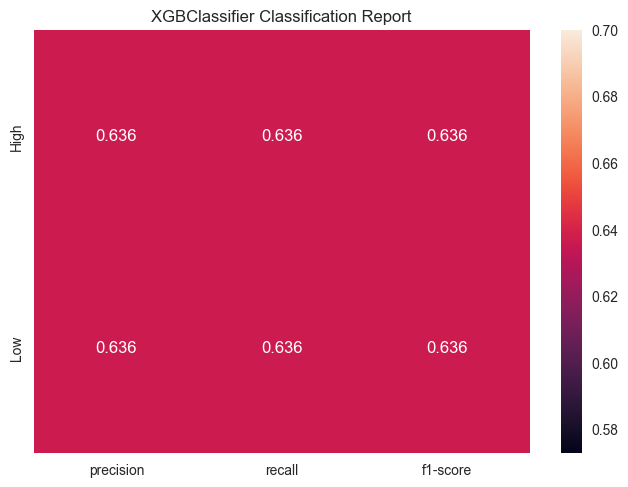

In [477]:
from sklearn.metrics import classification_report


model_name = model.__class__.__name__

report = classification_report(y, y_pred, target_names=classes, output_dict=True)

sns.heatmap(pd.DataFrame(report).iloc[:-1, :-3].T, annot=True, fmt=".3f")

plt.title(f"{model_name} Classification Report")
plt.show()

In [478]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [479]:
accuracy_score(y, y_pred)

0.6363636363636364

In [480]:
precision_score(y, y_pred, average="weighted")

0.6363636363636364

In [481]:
recall_score(y, y_pred, average="weighted")

0.6363636363636364

In [482]:
f1_score(y, y_pred, average="weighted")

0.6363636363636364

In [483]:
from sklearn.metrics import roc_curve, roc_auc_score

roc_auc_score(y, y_pred_proba[:, 1])

0.7334710743801653

<Figure size 1000x1000 with 0 Axes>

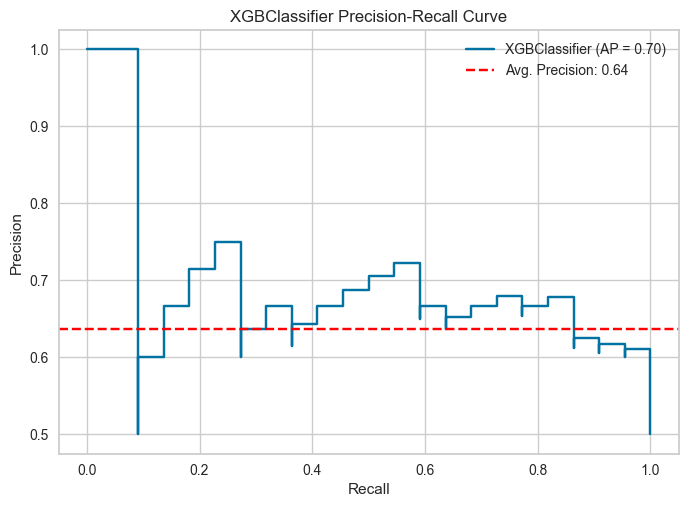

In [484]:
from sklearn.metrics import PrecisionRecallDisplay, precision_score

plt.figure(figsize=(10, 10))
display = PrecisionRecallDisplay.from_predictions(y, y_pred_proba[:, 1], name=f"{model.__class__.__name__}")

# plot avg precision
avg_precision = precision_score(y, y_pred, average="weighted")


plt.axhline(avg_precision, color="red", linestyle="--", label=f"Avg. Precision: {avg_precision:.2f}")

plt.setp(plt.gca(), xlabel="Recall", ylabel="Precision")

plt.title(f"{model.__class__.__name__} Precision-Recall Curve")

plt.legend()

plt.show()


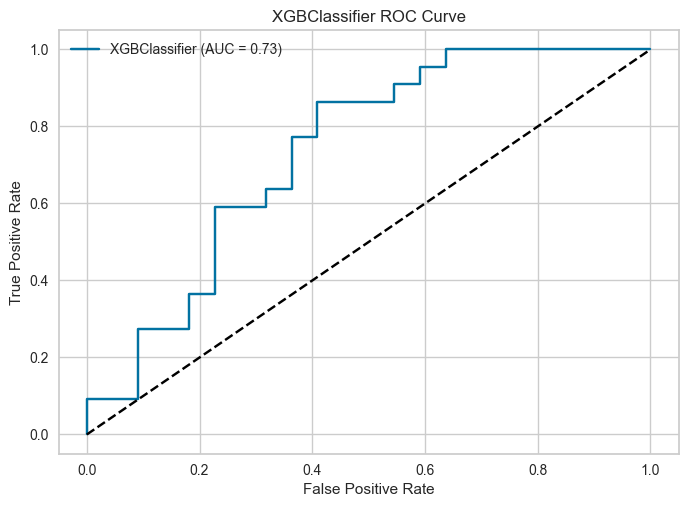

In [485]:
from sklearn.metrics import RocCurveDisplay


RocCurveDisplay.from_predictions(y, y_pred_proba[:, 1], pos_label=1, name=f"{model_name}")

sns.lineplot(
    x=[0, 1],
    y=[0, 1],
    color="black",
    linestyle="--",
)

plt.setp(plt.gca(), xlabel="False Positive Rate", ylabel="True Positive Rate")

plt.title(f"{model.__class__.__name__} ROC Curve")

plt.show()

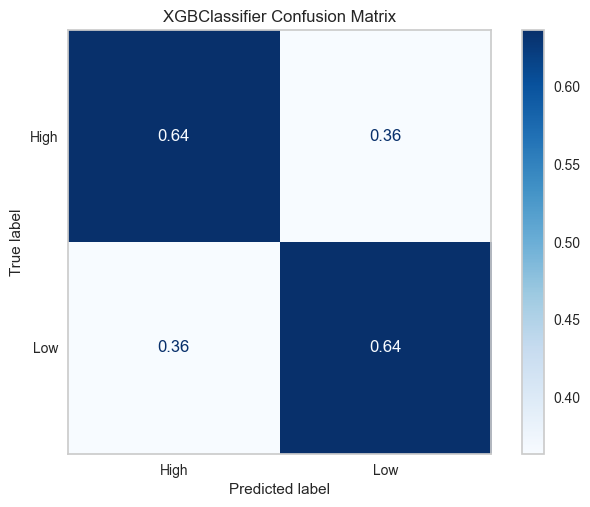

In [486]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y,
    y_pred,
    display_labels=classes,
    normalize="true",
    cmap="Blues",
)

plt.grid(False)

plt.title(f"{model.__class__.__name__} Confusion Matrix")

plt.show()



# Iteratively Redo Everything with selected model

In [487]:
%%script false --no-raise-error
model = xgb.XGBClassifier(
    n_estimators=study.best_params["n_estimators"],
    max_depth=int(study.best_params["max_depth"]),
    learning_rate=study.best_params["learning_rate"],
    subsample=study.best_params["subsample"],
    colsample_bytree=study.best_params["colsample_bytree"],
    random_state=42,
)


cv = model_selection.LeaveOneOut()

for direction in ["forward", "backward"]:
    print("Direction:", direction)
    print()
    sfs = SequentialFeatureSelector(
        model, n_features_to_select="auto", direction=direction, cv=cv
    )
    sfs.fit(X, y)
    print(X.columns[sfs.get_support()])
    print("-" * 10)

In [488]:
%%script false --no-raise-error
# Drop the features that are not selected at least half of the times

# Comment this line to keep all features
# %%script false --no-raise-error

X_selected = X.drop(
    columns=[
        "cso_sea",
        "cso_hinterland",
        "cso_middle",
    ]
)

In [489]:
%%script false --no-raise-error
from sklearn import model_selection


def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)
    max_depth = int(trial.suggest_float("max_depth", 10, 100, log=True))
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1, log=True)
    subsample = trial.suggest_float("subsample", 0.1, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0)
    model = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42,
    )

    cv = model_selection.LeaveOneOut()
    results = model_selection.cross_val_score(
        estimator=model, X=X, y=y, cv=cv, scoring="f1_weighted"
    )
    return results.mean()

In [490]:
%%script false --no-raise-error
study = optuna.create_study(
    direction="maximize",
)
study.optimize(objective, n_trials=100, show_progress_bar=True)